In [ ]:
########################################################################################################################
# Filename: threshold_learning_demo.ipynb
#
# Purpose: Demonstrate the use of the 'threshold_learning' library for multi-label
#          classification tasks.
#
# Author(s): Bobby (Robert) Lumpkin
#
# Library Dependencies: numpy, pandas, tensorflow, bpmll, threshold_learning
########################################################################################################################

# Threshold Learning Demonstration for Multi-Label Classification

In [1]:
## Import necessary modules
from scipy.io import arff
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn import metrics
from bpmll import bp_mll_loss
import matplotlib.pyplot as plt

## Load and Prep the Data

Let's start by loading in our data. We'll be using the `Yeast` dataset which can be found <a href = "http://www.uco.es/kdis/mllresources/">here</a>. As the description from the link states: "this dataset contains micro-array expressions and phylogenetic profiles for 2417 yeast genes. Each gene is annotated with a subset of 14 functional categories (e.g. Metabolism, energy, etc.) of the top level of the functional catalogue.". The training set is loaded as a pandas datarame, below.

In [2]:
## Load the 'Yeast' dataset
data_train = arff.loadarff('Yeast/Yeast-train.arff')
df_train = pd.DataFrame(data_train[0])

df_train.head()

,Att1,Att2,Att3,Att4,Att5,Att6,Att7,Att8,Att9,Att10,...,Class5,Class6,Class7,Class8,Class9,Class10,Class11,Class12,Class13,Class14
0,0.093700,0.139771,0.062774,0.007698,0.083873,-0.119156,0.073305,0.005510,0.027523,0.043477,...,b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0'
1,-0.022711,-0.050504,-0.035691,-0.065434,-0.084316,-0.378560,0.038212,0.085770,0.182613,-0.055544,...,b'0',b'0',b'1',b'1',b'0',b'0',b'0',b'1',b'1',b'0'
2,-0.090407,0.021198,0.208712,0.102752,0.119315,0.041729,-0.021728,0.019603,-0.063853,-0.053756,...,b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'1',b'1',b'0'
3,-0.085235,0.009540,-0.013228,0.094063,-0.013592,-0.030719,-0.116062,-0.131674,-0.165448,-0.123053,...,b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'1',b'1',b'1'
4,-0.088765,-0.026743,0.002075,-0.043819,-0.005465,0.004306,-0.055865,-0.071484,-0.159025,-0.111348,...,b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0'


### Conversion to Floats & Numpy Arrays 
The label indicators are loaded as bytes literals. We'll convert them to floats and generate numpy arrays of covariate and label values, to be used for training later.

In [3]:
## Convert the class labels into floats
label_names = []
for name in df_train.columns:
    if "Class" in name:
        label_names.append(name)
df_train[label_names] = df_train[label_names].astype("float")
df_train.head()

,Att1,Att2,Att3,Att4,Att5,Att6,Att7,Att8,Att9,Att10,...,Class5,Class6,Class7,Class8,Class9,Class10,Class11,Class12,Class13,Class14
0,0.093700,0.139771,0.062774,0.007698,0.083873,-0.119156,0.073305,0.005510,0.027523,0.043477,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.022711,-0.050504,-0.035691,-0.065434,-0.084316,-0.378560,0.038212,0.085770,0.182613,-0.055544,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
2,-0.090407,0.021198,0.208712,0.102752,0.119315,0.041729,-0.021728,0.019603,-0.063853,-0.053756,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
3,-0.085235,0.009540,-0.013228,0.094063,-0.013592,-0.030719,-0.116062,-0.131674,-0.165448,-0.123053,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
4,-0.088765,-0.026743,0.002075,-0.043819,-0.005465,0.004306,-0.055865,-0.071484,-0.159025,-0.111348,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
X_train = df_train[np.setdiff1d(df_train.columns, label_names)].to_numpy()
Y_train = df_train[label_names].to_numpy()

## Define and Train a Network Using Cross Entropy Loss 

We'll start with a two-layered network, utilizing a standard cross-entropy loss function. This is in contrast to the novel multi-label loss function: "BP-MLL" discussed in Zhang & Zhou (2006). We will fit an identical network architecture using BP-MLL later on, for comparison. Note, we're using relu and sigmoid activations, dropout regularization, and Adagrad optimization. This is due to intuitions from Nam et al. (2014) where results for networks using 'standard' losses performed as well, or better than BP-MLL when using similar designs.

In [5]:
## Load the test data
data_test = arff.loadarff('Yeast/Yeast-test.arff')
df_test = pd.DataFrame(data_test[0])
df_test[label_names] = df_test[label_names].astype("float")
X_test = df_test[np.setdiff1d(df_test.columns, label_names)].to_numpy()
Y_test = df_test[label_names].to_numpy()

df_test.head()

,Att1,Att2,Att3,Att4,Att5,Att6,Att7,Att8,Att9,Att10,...,Class5,Class6,Class7,Class8,Class9,Class10,Class11,Class12,Class13,Class14
0,0.004168,-0.170975,-0.156748,-0.142151,0.058781,0.026851,0.197719,0.041850,0.066938,-0.056617,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
1,-0.103956,0.011879,-0.098986,-0.054501,-0.007970,0.049113,-0.030580,-0.077933,-0.080529,-0.016267,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.509949,0.401709,0.293799,0.087714,0.011686,-0.006411,-0.006255,0.013646,-0.040666,-0.024447,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
3,0.119092,0.004412,-0.002262,0.072254,0.044512,-0.051467,0.074686,-0.007670,0.079438,0.062184,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.042037,0.007054,-0.069483,0.081015,-0.048207,0.089446,-0.004947,0.064456,-0.133387,0.068878,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
## Start with standard cross-entropy loss (bpmll used later)
tf.random.set_seed(123)

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, activation = 'relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(14, activation = 'sigmoid')
])

optim_func = tf.keras.optimizers.Adagrad(
    learning_rate = 0.001, initial_accumulator_value = 0.1, epsilon = 1e-07,
    name = 'Adagrad')

metric = tfa.metrics.HammingLoss(mode = 'multilabel', threshold = 0.5)

model.compile(optimizer = optim_func,
              loss = 'binary_crossentropy',
              metrics = metric
              )

In [7]:
history_ce = model.fit(X_train, Y_train, epochs = 20,
                       validation_data = (X_test, Y_test), verbose=2)

Epoch 1/20
47/47 - 2s - loss: 0.6921 - hamming_loss: 0.4819 - val_loss: 0.6920 - val_hamming_loss: 0.4812
Epoch 2/20
47/47 - 0s - loss: 0.6910 - hamming_loss: 0.4690 - val_loss: 0.6906 - val_hamming_loss: 0.4688
Epoch 3/20
47/47 - 0s - loss: 0.6895 - hamming_loss: 0.4556 - val_loss: 0.6893 - val_hamming_loss: 0.4572
Epoch 4/20
47/47 - 0s - loss: 0.6884 - hamming_loss: 0.4471 - val_loss: 0.6881 - val_hamming_loss: 0.4464
Epoch 5/20
47/47 - 0s - loss: 0.6868 - hamming_loss: 0.4400 - val_loss: 0.6869 - val_hamming_loss: 0.4342
Epoch 6/20
47/47 - 0s - loss: 0.6860 - hamming_loss: 0.4284 - val_loss: 0.6858 - val_hamming_loss: 0.4237
Epoch 7/20
47/47 - 0s - loss: 0.6846 - hamming_loss: 0.4166 - val_loss: 0.6847 - val_hamming_loss: 0.4138
Epoch 8/20
47/47 - 0s - loss: 0.6838 - hamming_loss: 0.4123 - val_loss: 0.6837 - val_hamming_loss: 0.4043
Epoch 9/20
47/47 - 0s - loss: 0.6828 - hamming_loss: 0.4032 - val_loss: 0.6826 - val_hamming_loss: 0.3959
Epoch 10/20
47/47 - 0s - loss: 0.6815 - hammin

## Compare Test Set Performance Using Constant and Learned Threshold Functions

Next, let's compare how test-set performance is affected when a constant threshold function is swapped out for a learned threshold function. After generating logit predictions, we'll first apply a constant threshold function ($t(x) \equiv 0.5$ -- the default) to generate binary predictions. Using hamming loss as a metric, we'll then evaluate how our model performed on the test set. In fact, we can just grab this value from the model's training history.

In [8]:
constant_ce = history_ce.history['val_hamming_loss'][19]
constant_ce

0.3255959451198578

Using a constant threshold value of $0.5$ yields a validation hamming loss of $\approx 0.33$. Next, we'll utilize the `predict_test_labels_binary()` function from the `threshold_learning` library to generate binary predictions from a learned threshold function. We find that the hamming loss can be significantly reduced.

In [9]:
## Learn a Threshold Function
Y_train_pred = model.predict(X_train)
Y_test_pred = model.predict(X_test)
t_range = (0, 1)
from threshold_learning import predict_test_labels_binary

test_labels_binary, threshold_function = predict_test_labels_binary(Y_train_pred, Y_train, Y_test_pred, t_range)
learnedTF_ce = metrics.hamming_loss(Y_test, test_labels_binary)
learnedTF_ce

0.30222776133354107

## Define and Train a Network Using BP-MLL Loss

Using the same architecture as in the previous example, we'll now learn a network using the BP-MLL loss function as described in Zhang & Zhao (2006). This loss function aims to increase model performance by minimizing pairwise errors. Namely, let $c_j^i$ denote the output of the label $j$ node of the  network for instance $i$. Furthermore, let $Y_i$ denote the label set of instance $i$ and $\overline{Y}_i$ denote it's complement, in the set of possible labels. Then, the BP-MLL loss is given by:

$$
    E = \sum_{i = 1}^m E_i = \sum_{i = 1}^m \frac{1}{|Y_i| |\overline{Y}_i|} \sum_{(k,l) \in Y_i \times \overline{Y}_i} \exp(-(c_k^i - c_l^i))
$$

so that the $i^{th}$ error term is severely penalized if $c_k^i$ is much smaller than $c_l^i$. 

In [10]:
## Start with bp-mll loss
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, activation = 'relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(14, activation = 'sigmoid')
])

optim_func = tf.keras.optimizers.Adagrad(
    learning_rate = 0.001, initial_accumulator_value = 0.1, epsilon = 1e-07,
    name = 'Adagrad')

model.compile(optimizer = optim_func,
              loss = bp_mll_loss,
              metrics = metric
              )

In [11]:
history_bpmll = model.fit(X_train, Y_train, epochs = 20,
                          validation_data = (X_test, Y_test), verbose=2)

Epoch 1/20
47/47 - 1s - loss: 0.9997 - hamming_loss: 0.4238 - val_loss: 0.9987 - val_hamming_loss: 0.4695
Epoch 2/20
47/47 - 0s - loss: 0.9989 - hamming_loss: 0.4763 - val_loss: 0.9977 - val_hamming_loss: 0.4639
Epoch 3/20
47/47 - 0s - loss: 0.9976 - hamming_loss: 0.4682 - val_loss: 0.9967 - val_hamming_loss: 0.4564
Epoch 4/20
47/47 - 0s - loss: 0.9972 - hamming_loss: 0.4625 - val_loss: 0.9958 - val_hamming_loss: 0.4494
Epoch 5/20
47/47 - 0s - loss: 0.9962 - hamming_loss: 0.4583 - val_loss: 0.9949 - val_hamming_loss: 0.4442
Epoch 6/20
47/47 - 0s - loss: 0.9953 - hamming_loss: 0.4512 - val_loss: 0.9941 - val_hamming_loss: 0.4378
Epoch 7/20
47/47 - 0s - loss: 0.9941 - hamming_loss: 0.4467 - val_loss: 0.9932 - val_hamming_loss: 0.4315
Epoch 8/20
47/47 - 0s - loss: 0.9937 - hamming_loss: 0.4408 - val_loss: 0.9924 - val_hamming_loss: 0.4267
Epoch 9/20
47/47 - 0s - loss: 0.9928 - hamming_loss: 0.4325 - val_loss: 0.9917 - val_hamming_loss: 0.4213
Epoch 10/20
47/47 - 0s - loss: 0.9919 - hammin

## Compare Test Set Performance Using Constant and Learned Threshold Functions

Again, we'll grab the hamming loss on our test data from the model's training history and compare it with the loss when using a learned threshold function.

In [12]:
constant_bpmll = history_bpmll.history['val_hamming_loss'][19]
constant_bpmll

0.37638258934020996

In [13]:
## Learn a Threshold Function
Y_train_pred = model.predict(X_train)
Y_test_pred = model.predict(X_test)
t_range = (0, 1)
from threshold_learning import predict_test_labels_binary

test_labels_binary, threshold_function = predict_test_labels_binary(Y_train_pred, Y_train, Y_test_pred, t_range)
learnedTF_bpmll = metrics.hamming_loss(Y_test, test_labels_binary)
learnedTF_bpmll

0.31944228072908554

## Results

Text(0.5, 1.0, 'BPMLL vs Cross Entropy Training History')

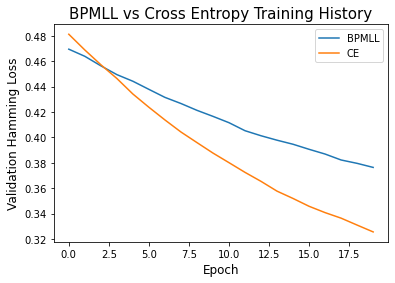

In [14]:
## Plot the results for the constant threshold networks throughout training
plt.plot(history_bpmll.history['val_hamming_loss'], label = 'BPMLL')
plt.plot(history_ce.history['val_hamming_loss'], label = 'CE')
plt.xlabel('Epoch', fontsize = 12)
plt.ylabel('Validation Hamming Loss', fontsize = 12)
plt.legend()
plt.title('BPMLL vs Cross Entropy Training History', fontsize = 15)

In [15]:
## Generate a dataframe with the validation hamming loss values using both constant and learned threshold values
results_df = pd.DataFrame({'Constant Threshold' : [constant_ce, constant_bpmll], 
                        'Learned Threshold' : [learnedTF_ce, learnedTF_bpmll]})
results_df.index = ['CE', 'BPMLL']
results_df

,Constant Threshold,Learned Threshold
CE,0.325596,0.302228
BPMLL,0.376383,0.319442


## Conclusion

We see here that performance with a learned threshold function improved upon performance with a constant $t(x) \equiv 0.5$ threshold, for both the cross entropy and BP-MLL networks. You'll notice that the training time devoted to each network is very small. If we train for a larger number of epochs, performance using both loss functions and constant thresholds improves significantly, to the point where a learned threshold function provides no additional lift. This suggests that threshold function learning may be most useful in cases where the resources necessary to sufficiently train a model are prohibitive. 

Another observtion: with both learned and constant threshold functions, a standard binary cross entropy loss function outperformed the networks with the novel BP-MLL loss. This mirrors the results found in Nam et al. (2014), where potential explanations are also provided. Namely (1) the surface for the BP-MLL loss has plateaus in which gradient descent can be very slow in comparison with the cross-entropy loss function. And(2) while BPMLL is supposed to leverage correlations between labels, Nam et al. conjecture that these correlations may also cause overfitting. If groups of hidden units specialize in predicting particular label subsets that occur frequently in the training data, it will become harder to predict novel label combinations that only occur in the test set. Furthermore, another obstacle with BPMLL is that the surface of the objective function has plateaus in which gradient descent can be very slow in comparison with the cross-entropy loss function. 

The superior generalizability of cross entropy would, in fact, be a desirable outcome, for the following reason. Since computing the BP-MLL loss involves pairwise computations, obtaining error terms is more expensive than utilizing cross-entropy or MSE loss. This scales poorly with the number of labels, and can lead to significantly larger training times. 


## References

* Jinseok Nam, Jungi Kim, Eneldo Loza Menc´ıa, Iryna Gurevych, and
Johannes F¨urnkranz. Large-scale multi-label text classification —
revisiting neural networks. In Toon Calders, Floriana Esposito, Eyke
H¨ullermeier, and Rosa Meo, editors, Machine Learning and Knowledge
Discovery in Databases, pages 437–452, Berlin, Heidelberg, 2014.
Springer Berlin Heidelberg. ISBN 978-3-662-44851-9.

* Min-Ling Zhang and Zhi-Hua Zhou. Ml-knn: A lazy learning approach to
multi-label learning. Pattern Recognition, 40(7):2038–2048, 2007. doi:
10.1016/j.patcog.2006.12.019.

* Min-Ling Zhang and Zhi-Hua Zhou. Multilabel neural networks with
applications to functional genomics and text categorization. IEEE
Transactions on Knowledge and Data Engineering, 18(10):1338–1351,
2006. doi: doi:10.1109/TKDE.2006.162.
